# Project 1 - Earnings, Gender, Education and Ability
## Professor: Costas Meghir. Econometrics 123, Fall 2019.  
### Author: Alexander Jeremijenko

In this report we will be analyzing a dataset tracking the wages of Swedish individuals born in either '48 or '53 as well as their various characteristics. The key questions which this report aims to answer are: 
1. What are the returns to education and how do they differ by gender?
2. How is the time/age profile of earnings shaped by education?
3. What are the differences between men and women in educational attainment and career profiles of earnings and how does the gender gap change with age?
4. What is the role of ability  in shaping the returns to education? Does this differ by gender

As a first step, we will clean and transform the data into a form more conducive to the goals of this report. The body of the report will then begin below. 

In [2]:
# including relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

In [3]:
# Importing the data
egea_df = pd.read_stata('Econ123proj2018.dta')
# From inflation.eu/en/inflation_rates/sweden
inflation_dic = {85: 1.0563, 86: 1.0332, 87: 1.0513, 88: 1.0598, 89: 1.0662, 90: 1.1090, 
                 91: 1.0792, 92: 1.0186, 93: 1.0408, 94: 1.0247, 95: 1.0211, 96: 0.9979}

# Defining function to transform the dictionary values into more useful scalar values
def inflation_transform(dic):
    for key in dic.keys():
        if key != min(dic.keys()):
            dic[key] = dic[key] * dic[key - 1]
    dic = {k: 1/dic[k] for k in dic.keys()}
    return dic
inflation_dic = inflation_transform(inflation_dic)

# adjusting earnings for inflation then recalculating lnearn
egea_df = egea_df[egea_df.earn > 1]
egea_df = egea_df.assign(inf_earn = lambda x: x.earn * x.year.map(inflation_dic))
egea_df['lnearn'] = np.log(egea_df['inf_earn'])

# Creating ages based on birth cohort and year sampled
egea_df = egea_df.assign(age = lambda x: x.year - 48 + (x.d53*5))

# Dropping all Nan values of yearsch (level = 8,9)
egea_df = egea_df[~((egea_df.level == 9) | (egea_df.level == 8))]

# converting level into dummies for ['compulsory', 'secondary', 'tertiary', 'phd']
egea_df['compulsory'] = np.where((egea_df.level == 1) | (egea_df.level == 2) | (egea_df.level == 3), 1, 0)
egea_df['secondary'] = np.where((egea_df.level == 4) | (egea_df.level == 5), 1, 0)
egea_df['tertiary'] = np.where((egea_df.level == 6), 1, 0)
egea_df['doctorate'] = np.where((egea_df.level == 7), 1, 0)

# Creating female x education dummies
egea_df = egea_df.assign(fem_compulsory = lambda x: x.compulsory * (1 - x.female))
egea_df = egea_df.assign(fem_secondary = lambda x: x.secondary * (1 - x.female))
egea_df = egea_df.assign(fem_tertiary = lambda x: x.tertiary * (1 - x.female))
egea_df = egea_df.assign(fem_doctorate = lambda x: x.doctorate * (1 - x.female))

# Making county dummies
egea_df = pd.concat([egea_df, pd.get_dummies(egea_df.cou.astype(str), prefix = 'cou')], axis = 1)

# Extracting our X and y
# Dropping dummies 'compulsory', 'fem_compulsory', 'cou_25.0' to avoid perfect collinearity
egea_df_X = sm.add_constant(egea_df.drop(['id', 'lnearn', 'year', 'earn', 'compulsory', 'fem_compulsory', 'cou_25.0', 'yearsch', 'cou', 'inf_earn', 'level'], axis = 1))
egea_df_y = egea_df[['lnearn']]
print('The cleaned data:')
display(egea_df_X)
display(egea_df_y)

print(f'field names are: \n {[*egea_df_X.columns]}')

The cleaned data:


,const,d53,female,reform,fe,abil1,age,secondary,tertiary,doctorate,...,cou_22.0,cou_23.0,cou_24.0,cou_3.0,cou_4.0,cou_5.0,cou_6.0,cou_7.0,cou_8.0,cou_9.0
0,1.0,0,0.0,0.0,2.0,0.101577,47,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0.0,0.0,1.0,-1.033465,37,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0.0,0.0,1.0,3.640584,38,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0.0,0.0,1.0,2.233250,44,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,1.0,0.0,1.0,-0.302084,46,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206559,1.0,1,0.0,1.0,1.0,-1.873930,50,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206560,1.0,1,1.0,1.0,0.0,-1.243812,49,0,0,0,...,0,0,0,1,0,0,0,0,0,0
206561,1.0,1,0.0,1.0,1.0,2.451722,47,1,0,0,...,0,0,0,0,0,0,0,0,1,0
206562,1.0,0,0.0,1.0,1.0,-0.209572,37,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,lnearn
0,7.214887
1,7.084095
2,7.547388
3,7.182854
4,6.940650
...,...
206559,7.071156
206560,7.260047
206561,5.429913
206562,6.918771


field names are: 
 ['const', 'd53', 'female', 'reform', 'fe', 'abil1', 'age', 'secondary', 'tertiary', 'doctorate', 'fem_secondary', 'fem_tertiary', 'fem_doctorate', 'cou_1.0', 'cou_10.0', 'cou_11.0', 'cou_12.0', 'cou_13.0', 'cou_14.0', 'cou_15.0', 'cou_16.0', 'cou_17.0', 'cou_18.0', 'cou_19.0', 'cou_20.0', 'cou_21.0', 'cou_22.0', 'cou_23.0', 'cou_24.0', 'cou_3.0', 'cou_4.0', 'cou_5.0', 'cou_6.0', 'cou_7.0', 'cou_8.0', 'cou_9.0']


Here we have our processed data that will be used in our regression analysis. The steps in processing the data were: <br>
1. Adjusting for inflation and then recalculating our dependent variable lnearn <br>
2. Generating ages for all people in the sample at each data point <br>
3. Dropping all NaN values or missing values for schooling. Seeing as there were only a few data-points in this classification, and since they do not fit into our broader categories (compulsory, secondary, tertiary, doctorate), it was decided that they can be omitted from the analysis. <br>
4. Dummies where then generated which categorize each person by education level (compulsory, secondary, tertiary, doctorate).
5. On top of that a female x education level dummy was generated
6. Then irrelevant and highly collinear variables where dropped
7. lnearn was chosen to be our dependent due to be the dependent due to skewed nature of earnings data

In [4]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 10)
    return pvalues


def color_cells(s, threshold=0.01):
    if s < threshold:
        return "color:{0}; font-weight:bold".format("red")
    else:
        return ""
    
pvalue_df = egea_df_X.drop('const', axis = 1).loc[:, 'd53':'fem_doctorate']
pvalue_mat = calculate_pvalues(pvalue_df)
correlation_mat = pvalue_df.corr()
correlation_mat = correlation_mat.style.apply(lambda x: pvalue_mat.applymap(color_cells), axis=None)
print("Statistically significant collinearity at 1%:")
display(correlation_mat)

Statistically significant collinearity at 1%:


,d53,female,reform,fe,abil1,age,secondary,tertiary,doctorate,fem_secondary,fem_tertiary,fem_doctorate
d53,1.000000,0.001726,0.464387,-0.088828,0.016941,0.588854,0.004086,-0.056034,-0.028460,-0.028444,-0.037402,-0.020864
female,0.001726,1.000000,0.006977,-0.005104,0.072117,0.010861,-0.011469,-0.012549,-0.035604,-0.374528,-0.282684,-0.066735
reform,0.464387,0.006977,1.000000,0.001181,0.010208,0.273053,0.029139,0.001810,-0.009786,0.005822,-0.001236,0.000876
fe,-0.088828,-0.005104,0.001181,1.000000,0.128586,-0.052146,0.053208,0.162271,0.050092,0.033243,0.117375,0.047142
abil1,0.016941,0.072117,0.010208,0.128586,1.000000,0.017174,0.218227,0.391422,0.100699,0.102544,0.257980,0.079241
age,0.588854,0.010861,0.273053,-0.052146,0.017174,1.000000,0.006283,-0.027316,-0.015643,-0.016311,-0.019105,-0.011526
secondary,0.004086,-0.011469,0.029139,0.053208,0.218227,0.006283,1.000000,-0.236276,-0.045444,0.671531,-0.164832,-0.038913
tertiary,-0.056034,-0.012549,0.001810,0.162271,0.391422,-0.027316,-0.236276,1.000000,-0.033017,-0.158666,0.697627,-0.028272
doctorate,-0.028460,-0.035604,-0.009786,0.050092,0.100699,-0.015643,-0.045444,-0.033017,1.000000,-0.030517,-0.023034,0.856284
fem_secondary,-0.028444,-0.374528,0.005822,0.033243,0.102544,-0.016311,0.671531,-0.158666,-0.030517,1.000000,-0.110690,-0.026131


In this dataset, we have a high amount of statistically significant multicollinearity. However, due to the quantity of data being very high, this will hopefully not result in imprecise estimates. 

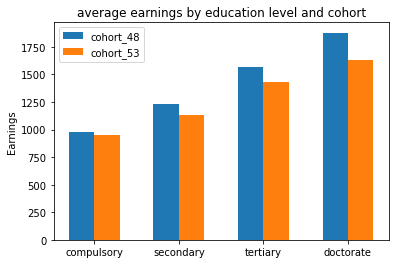

In [5]:
# Plotting the counties ranked by average income against the normalized lnearn
income_means = egea_df[['compulsory', 'secondary', 'tertiary', 'doctorate', 'd53', 'inf_earn']].groupby(
                       ['compulsory', 'secondary', 'd53', 'tertiary', 'doctorate'], as_index = False).mean()
cohort_48 = income_means[income_means.d53 == 0].inf_earn.iloc[::-1]
cohort_53 = income_means[income_means.d53 == 1].inf_earn.iloc[::-1]
labels = ['compulsory', 'secondary', 'tertiary', 'doctorate']
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cohort_48, width, label='cohort_48')
rects2 = ax.bar(x + width/2, cohort_53, width, label='cohort_53')

ax.set_ylabel('Earnings')
ax.set_title('average earnings by education level and cohort')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

In this first figure, we see the foreseeable outcome that earnings is positively correlated with education, what is left to be analyzed, is whether this relationship is causal and how it differs between men and women. <br>
Here, we can also see here a discrepancy in the earnings between the two cohorts. This would be due to a difference in age, with the '48 cohort being older and therefore having higher wages on average.

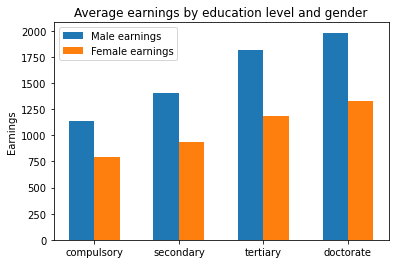

In [17]:
# Plotting the average earnings of men and women at each educational level
income_means = egea_df[['compulsory', 'secondary', 'tertiary', 'doctorate', 'female', 'inf_earn']].groupby(
                       ['compulsory', 'secondary', 'tertiary', 'doctorate', 'female',], as_index = False).mean()
income_means

cohort_48 = income_means[income_means.female == 0].inf_earn.iloc[::-1]
cohort_53 = income_means[income_means.female == 1].inf_earn.iloc[::-1]
labels = ['compulsory', 'secondary', 'tertiary', 'doctorate']
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cohort_48, width, label='Male earnings')
rects2 = ax.bar(x + width/2, cohort_53, width, label='Female earnings')

ax.set_ylabel('Earnings')
ax.set_title('Average earnings by education level and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

This plot shows the infamous gender gap. At all levels of education, women earn much less than men. In this report, we will be looking at what part education and ability has in shaping this gap. 

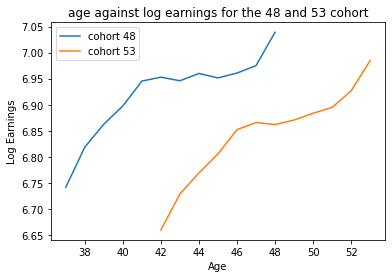

In [7]:
Xy = egea_df[['age', 'd53', 'lnearn']].groupby(['age', 'd53'], as_index = False).mean()
cohort_48 = Xy[Xy.d53 == 0]
cohort_53 = Xy[Xy.d53 == 1]
plt.plot(cohort_48['age'], cohort_48['lnearn'], label = 'cohort 48')
plt.plot(cohort_53['age'], cohort_53['lnearn'], label = 'cohort 53')
plt.xlabel('Age')
plt.ylabel('Log Earnings')
plt.title('age against log earnings for the 48 and 53 cohort')
plt.legend(loc = 'upper left')
plt.show()

In this figure, the general profile of earnings against age in the 40s - 50s age group is made apparent. The shape of this profile is remarkably similar across cohorts, most likely reflecting how the broader economic trends of the time were impacting wages. <br>
The vertical separation of the lines is a reflection of the economic growth of Sweden. At the same age, the younger cohort would be expected to earn more, since the economy would have grown since the time the former cohort was sampled at that age, and this is what we are seeing here. 

Now, before we begin the regression analysis, a check for heteroskedasticity. The check will be made by seeing if there is statistically significant covariance between the residuals of the OLS regression and the X independents. 

In [1]:
# First make predictions for y
model_1 = sm.OLS(egea_df_y, egea_df_X).fit()
predict = model_1.predict(egea_df_X)
# Generate the residuals
residuals_sq = np.square((predict - egea_df_y.iloc[:, 0]).values)
# Regress X and e
model_2 = sm.OLS(residuals_sq, egea_df_X).fit()
model_summary = model_2.summary().as_text().split('\n')
for li in model_summary:
    if li.startswith('Notes'):
        break
    if not li.startswith('cou'):
        print(li)

NameError: name 'sm' is not defined

We have statistically significant heteroskedasticty on the majority of variables. Therefore, we will be using White robust standard errors. 

## Q1: The returns to education and how this differs by gender

Now that we have transformed and cleaned the data, made some basic visualizations of what it looks like, and identified heteroskedasticity. We can tackle the first question of this report: What are the returns to education and how do they differ by gender? 

In [9]:
# Overall heteroskedastic robust results including all X
model = sm.OLS(egea_df_y, egea_df_X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')
# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou'):
        print(li) 

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     1912.
Date:                Sat, 07 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:38:03   Log-Likelihood:            -1.3829e+05
No. Observations:              206487   AIC:                         2.766e+05
Df Residuals:                  206451   BIC:                         2.770e+05
Df Model:                          35                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1067      0.014    428.841

This is our first regression of X on earnings and a general summary of the data we are working with. All coefficients displayed here are significant at the 5% level except for the one on the father's education variable. Some significant results are the positively increasing returns to education, and the positive coefficients on the female education dummies (fem_secondary, fem_tertiary, fem_doctorate). What this is suggesting is that females have a higher return to education at all levels than males in this sample.  <br> 

Other intuitive results are that ability and age are positively correlated with earnings, and that those born in the younger cohort are making less. <br>

Now a visualization of what these results look like. 

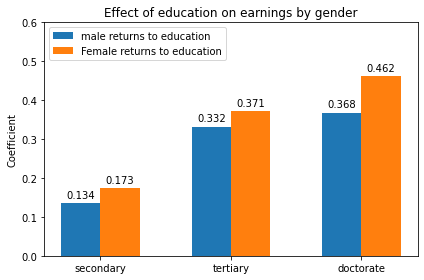

In [18]:
# Turning results table into operable dataframe
results_as_html = model.summary().tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

# extracting education coeffeicients
ed_coefs = results_df.loc[['secondary', 'tertiary', 'doctorate'], 'coef'].values
# Adding female educ dummy to educ coefficient
femed_increment = results_df.loc[['fem_secondary', 'fem_tertiary', 'fem_doctorate'], 'coef'].values
femed_coefs = femed_increment + ed_coefs

# making bar graph
labels = ['secondary', 'tertiary', 'doctorate']
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ed_coefs, width, label='male returns to education')
rects2 = ax.bar(x + width/2, femed_coefs, width, label='Female returns to education')

ax.set_ylabel('Coefficient')
ax.set_title('Effect of education on earnings by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 0.6)
ax.legend(loc = 'upper left')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

What we see here visually is that education is increasing log earnings for females more than it is for males. Since we are working with log earnings here, this can be interpreted as percentage difference, i.e. the benefit for women who complete their tertiary education over men is approximately 4 percent, because 0.332 - 0.371 is 0.04, and adding ln(0.04) is approximately equivalent to an increase of 4 percent. Based on that, what we have here in percentage terms is:

In [11]:
print('approximate % benefit over males that females gain by completing a level of education:')
display((round(results_df.loc[['fem_secondary', 'fem_tertiary', 'fem_doctorate'], 'coef']*100, 3).astype(str) + '%'))

approximate % benefit over males that females gain by completing a level of education:


fem_secondary    3.87%
fem_tertiary     3.92%
fem_doctorate     9.4%
Name: coef, dtype: object

Overall, the returns to education are positively increasing, and are larger for females.

## Q2: How is the time/age profile of earnings shaped by education?

Now moving on to the second question: How is the time/age profile of earnings shaped by education? <br>

To answer this we will first construct a new data frame with dummy interactions between earnings and education level

In [616]:
# Creating a dataframe with dummy interactions between age and education for secondary, tertiary, and doctorate
egea_X_2 = egea_df_X.assign(secondary_age = lambda x: x.age * x.secondary)
egea_X_2 = egea_X_2.assign(tertiary_age = lambda x: x.age * x.tertiary)
egea_X_2 = egea_X_2.assign(doctorate_age = lambda x: x.age * x.doctorate)
# Dropping fem_education for this regression
egea_X_2 = egea_X_2.drop(['fem_secondary', 'fem_tertiary', 'fem_doctorate'], axis = 1)

# Overall heteroskedastic robust results including all X
model = sm.OLS(egea_df_y, egea_X_2).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')
# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     1894.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:00:53   Log-Likelihood:            -1.3832e+05
No. Observations:              206487   AIC:                         2.767e+05
Df Residuals:                  206451   BIC:                         2.771e+05
Df Model:                          35                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1487      0.017    355.173

Immediately it can be seen that introducing this derivative data has significantly increased variance within the age and education level variables. The standard error of the coefficients has increased significantly, and the coefficient on doctorate_age is now not significant at the 5% level. <br>

Nevertheless, the general trend that is displayed here is that those who pursue higher education have marginally higher increase in salary year after year. I.e those who have completed tertiary education on average will have salary increases of 1 + .021 (age) + .0022 (tertiary age) = 1.0232 (2.32%) per year. As opposed to those who just did not pursue any further education after compulsory education 2.1% per year. 

A figure to help us visualize this:

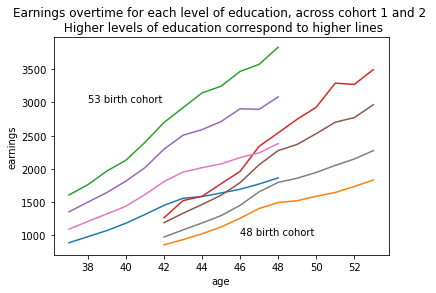

In [617]:
mean_groups = egea_df[['age', 'd53', 'earn', 'secondary', 'tertiary', 'doctorate']].groupby(['age', 'secondary', 'tertiary', 'doctorate', 'd53'], as_index = False).mean()
sub_groups = mean_groups.groupby(['secondary', 'tertiary', 'doctorate', 'd53'])
group_list = [sub_groups.get_group(x) for x in sub_groups.groups]

for group in group_list:
    plt.plot(group.age, group.earn)

plt.xlabel('age')
plt.ylabel('earnings')
plt.title('Earnings overtime for each level of education, across cohort 1 and 2 \n Higher levels of education correspond to higher lines')
plt.annotate('48 birth cohort', (46, 1000))
plt.annotate('53 birth cohort', (38, 3000))
plt.show()

In this figure, what we can see is that there is a slightly higher slope for higher education levels. This visual representation is in line with what we discovered in our regression analysis. 

So we can conclude that those who have attained a higher level of education are expected to see higher wage growth over time, as reflected by our analysis and our visualization.

## Q3: What are the differences between men and women in educational attainment and career profiles of earnings? How does the gender gap change with age?


To address this question we will be using the dependent variable years of schooling. First, some data visualizations. 

In [618]:
egea_X_3 = pd.concat([egea_df_X, egea_df['yearsch']], axis = 1)
avg_school = egea_X_3[['female', 'yearsch']].groupby('female').mean()
print("Mean years of schooling for male and females are:")
avg_school

Mean years of schooling for male and females are:


,yearsch
female,
0.0,11.54423
1.0,11.62456


Females and males on average complete about the same amount of schooling, with females in fact completing a bit more. 

In [619]:
# Male and female count:
fem_sum = (egea_X_3.female == 0).sum()
mal_sun = (egea_X_3.female == 1).sum()

edu_counts = egea_df[['female', 'compulsory', 'secondary', 'tertiary', 'doctorate']].groupby('female').sum()
edu_percents = round((edu_counts.apply(lambda x: x/x.sum(), axis = 1) * 100), 2).astype(str) + '%'
print('Percentage of each gender achieving each level of education:')
edu_percents

Percentage of each gender achieving each level of education:


,compulsory,secondary,tertiary,doctorate
female,,,,
0.0,58.99%,25.02%,15.09%,0.91%
1.0,61.42%,24.04%,14.2%,0.34%


As can be seen here the distribution of genders at each level of education is also similar. The area where there is the greatest discrepancy is at the doctorate level, where males dominate, but that is a small fraction. This should be reflected by small or insignificant coefficients on gender in a regression of years of schooling against our X: 

In [620]:
egea_y_3 = egea_df['yearsch']
egea_X_3 = egea_X_3.drop(['yearsch', 'secondary', 'tertiary', 'doctorate', 'fem_secondary', 'fem_tertiary', 'fem_doctorate', 'age'], axis = 1)

model = sm.OLS(egea_y_3, egea_X_3).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')

# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                yearsch   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     3232.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:00:55   Log-Likelihood:            -4.6973e+05
No. Observations:              206487   AIC:                         9.395e+05
Df Residuals:                  206458   BIC:                         9.398e+05
Df Model:                          28                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2789      0.029    386.125      0.0

The results here show that being female is slightly but significantly negatively correlated with education. This is interesting given that the average education attained by females is in fact higher, suggesting that there are other variables correlated with the female dummy which are explaining that higher average - perhaps ability or the county dummies. <br>

Turning to the second part of the question, here is a visualization of how the earnings profile of men and women looks like over time:

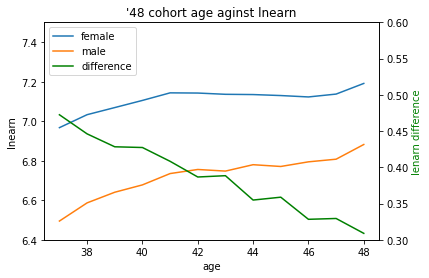

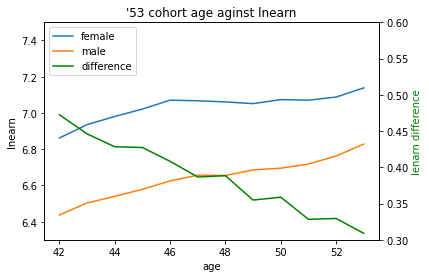

In [621]:
# grouping by gender and birth cohort
Xy = egea_df[['age', 'd53', 'female', 'lnearn']].groupby(['age', 'female', 'd53'], as_index = False).mean()
sub_groups = Xy.groupby(['d53','female'])
group_list = [sub_groups.get_group(x) for x in sub_groups.groups]
diff_48 = group_list[0].lnearn.values - group_list[1].lnearn.values
diff_53 = group_list[2].lnearn.values - group_list[3].lnearn.values

group_list = [sub_groups.get_group(x) for x in sub_groups.groups]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(group_list[0].age, group_list[0].lnearn, label = 'female')
lns2 = ax1.plot(group_list[1].age, group_list[1].lnearn, label = 'male')
lns3 = ax2.plot(group_list[1].age, diff_48, label = 'difference', color = 'green')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left')
ax1.set_title('\'48 cohort age aginst lnearn')
ax1.set_xlabel('age')
ax1.set_ylabel('lnearn')
ax1.set_ylim((6.4, 7.5))
ax2.set_ylabel('lenarn difference', color= 'green') 
ax2.set_ylim((0.3, 0.6))
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(group_list[2].age, group_list[2].lnearn, label = 'female')
lns2 = ax1.plot(group_list[3].age, group_list[3].lnearn, label = 'male')
lns3 = ax2.plot(group_list[2].age, diff_48, label = 'difference', color = 'green')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc= 'upper left')
ax1.set_title('\'53 cohort age aginst lnearn')
ax1.set_xlabel('age')
ax1.set_ylabel('lnearn')
ax1.set_ylim((6.3, 7.5))
ax2.set_ylabel('lenarn difference', color= 'green') 
ax2.set_ylim((0.3, 0.6))
plt.show()

These figures visualize the decrease in the gap between lnearn for males and females as age increases. Now carrying out a regression to verify this. 

In [622]:
# adding a female age interaction
X = egea_df_X.assign(fem_age = lambda x: x.age * x.female)
model = sm.OLS(egea_df_y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')

# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1870.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:00:57   Log-Likelihood:            -1.3817e+05
No. Observations:              206487   AIC:                         2.764e+05
Df Residuals:                  206450   BIC:                         2.768e+05
Df Model:                          36                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.2674      0.018    345.949

Here we see the positive interaction between the female dummy and age, which implies that the gender gap will decrease over time. <br>
Overall, the data suggests that there is minimal difference between men and women in terms of educational attainment (years studied) and that the gender gap decreases with age (but never disappears). The mechanism for this is unclear, perhaps as a woman ages and her status increases, she is able to demand more equitable pay, as compared to when she was young and she might not have had the ability to fight for fair wages. 

## Q4 what is the role of ability in shaping the returns to education and the age profile of earnings? Does this differ by gender?

In [623]:
# Make dummy interactions between education dummies and ability
X = egea_df_X.drop(['fem_secondary', 'fem_tertiary', 'fem_doctorate'], axis = 1)
X = X.assign(abil_sec = lambda x: x.abil1 * x.secondary)
X = X.assign(abil_tert = lambda x: x.abil1 * x.tertiary)
X = X.assign(abil_doct = lambda x: x.abil1 * x.doctorate)
model = sm.OLS(egea_df_y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')

# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1909.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:00:58   Log-Likelihood:            -1.3825e+05
No. Observations:              206487   AIC:                         2.766e+05
Df Residuals:                  206451   BIC:                         2.769e+05
Df Model:                          35                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1134      0.014    430.120      0.0

What we see in this regression is positive interactions between ability and higher education. For those who have completed tertiary education, the returns to ability double (0.0175 + 0.0162), and the affect is larger for those who have obtained a doctorate. The causality of this relationship seems plausible, it makes sense that if a smart person has access to a education they are going to have higher returns then a person who might struggle to get their degree. It is also interesting that there is a negative (although small) coefficient on abil_sec, this might be reflecting that the earnings of those with just a secondary education does not depend as much on this measure of ability, but perhaps more on a measure such as technical skill or soft skills. Whatever the true reason, it is interesting that the returns to ability for those who have only completed compulsory education is higher than for those who completed secondary. <br>

Now the same regression with a female dummy interaction added to see if there is any gender based differences in returns to education. 

In [624]:
# Make dummy interactions between education dummies and ability
X = X.assign(abil1_fem = lambda x: x.abil1 * x.female)
X = X.assign(abil_sec_fem = lambda x: x.abil_sec * x.female)
X = X.assign(abil_tert_fem = lambda x: x.abil_tert * x.female)
X = X.assign(abil_doct_fem = lambda x: x.abil_doct * x.female)
model = sm.OLS(egea_df_y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')

# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1721.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:00:59   Log-Likelihood:            -1.3824e+05
No. Observations:              206487   AIC:                         2.766e+05
Df Residuals:                  206447   BIC:                         2.770e+05
Df Model:                          39                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1140      0.014    429.760

At a 1 percent significance level, the returns to ability for females are lower than they are for males (abil1_fem = -0.0047), however, this is not a particularly large effect. Further, this regression is unable to say that the additional returns to ability for females who have obtained a secondary or tertiary level of education (abil_sec_fem and abil_tert_fem) are statistically different from 0. We do, however, see significantly lower returns to education for female doctorate holders. However, this is a small sample in our data set, more data collection would need to be done to verify this relationship.   

Here is a visualization of what this looks like:

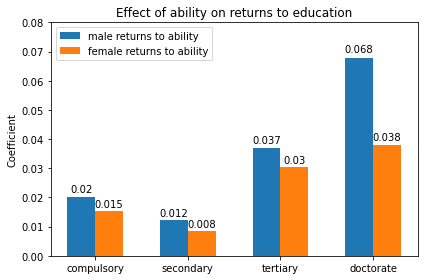

In [625]:
# Turning results table into operable dataframe
results_as_html = model.summary().tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

# extracting ability coeffeicients
abil = results_df.loc['abil1', 'coef']
fem_abil = abil_coef + results_df.loc['abil1_fem', 'coef']
sec_abil = abil + results_df.loc['abil_sec', 'coef']
sec_abil_fem = fem_abil + results_df.loc['abil_sec', 'coef'] + results_df.loc['abil_sec_fem', 'coef']
tert_abil = abil + results_df.loc['abil_tert', 'coef']
tert_abil_fem =  fem_abil + results_df.loc['abil_tert', 'coef'] + results_df.loc['abil_tert_fem', 'coef']
doct_abil = abil + results_df.loc['abil_doct', 'coef']
doct_abil_fem = fem_abil + results_df.loc['abil_doct', 'coef'] + results_df.loc['abil_doct_fem', 'coef']

m_coefs = [abil, sec_abil, tert_abil, doct_abil]
f_coefs = [fem_abil, sec_abil_fem, tert_abil_fem, doct_abil_fem]

# making bar graph
labels = ['compulsory', 'secondary', 'tertiary', 'doctorate']
x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, m_coefs, width, label='male returns to ability')
rects2 = ax.bar(x + width/2, f_coefs, width, label='female returns to ability')

ax.set_ylabel('Coefficient')
ax.set_title('Effect of ability on returns to education')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 0.08)
ax.legend(loc = 'upper left')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

As can be seen, the returns to ability given education is lower for women. This is particularly interesting considering that the returns to education for women is higher than that for men (as found above). A plausible explanation for this might be that women get more out of education regardless of inherent ability (perhaps due to a stronger work ethic), whereas males without strong ability might not be able to take as well advantage of the resources of a learning institution. Isolating the causality here would be an interesting exercise.  

To explore the effect of ability on the age profile of earnings, we will divide the ability variable into 4 dummies of first_q_abil, second_q_abil, third_q_abil and fourth_q_abil (four quartiles) and see how these dummies interact with the age variable when predicting earnings. 

In [626]:
# make quartiles
egea_df_X['abil_quartiles'] = pd.qcut(egea_df_X['abil1'], 4, labels=False) + 1
# put them into df
X = pd.concat([egea_df_X, pd.get_dummies(egea_df_X.abil_quartiles.astype(str), prefix = 'abil_quart')], axis = 1)
# create dummy interactions with age
X = X.assign(age_abilq2 = lambda x: x.age * x.abil_quart_2)
X = X.assign(age_abilq3 = lambda x: x.age * x.abil_quart_3)
X = X.assign(age_abilq4 = lambda x: x.age * x.abil_quart_4)
# Drop unneccessary columns
X = X.drop(['abil_quartiles', 'abil1', 'abil_quart_1', 'abil_quart_2', 'abil_quart_3', 'abil_quart_4'], axis = 1)

# plot
model = sm.OLS(egea_df_y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')

# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou') and not li.startswith('fem_'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     1804.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:01:00   Log-Likelihood:            -1.3835e+05
No. Observations:              206487   AIC:                         2.768e+05
Df Residuals:                  206449   BIC:                         2.772e+05
Df Model:                          37                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1048      0.014    428.546

What we see here is that ability is positively correlated with wage growth over time - people with higher abilities on average have higher yearly wage increases. These results are statistically significant, however, the affect is not too pronounced - for example being in quartile four for ability only increases yearly wage growth by approx .19% (0.0019). 

Now checking if these affects vary across gender. 

In [627]:
# create dummy interactions with fem
X = X.assign(age_fe = lambda x: x.age * x.female)
X = X.assign(age_abilq2_fe = lambda x: x.age_abilq2 * x.female)
X = X.assign(age_abilq3_fe = lambda x: x.age_abilq3 * x.female)
X = X.assign(age_abil4_fe = lambda x: x.age_abilq4 * x.female)

# plot
model = sm.OLS(egea_df_y, X).fit(cov_type = 'HC3')
model_summary = model.summary().as_text().split('\n')

# removing dummies
for li in model_summary:
    if li.startswith('Notes'):
        break  
    if not li.startswith('cou') and not li.startswith('fem'):
        print(li)

                            OLS Regression Results                            
Dep. Variable:                 lnearn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1639.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:01:01   Log-Likelihood:            -1.3823e+05
No. Observations:              206487   AIC:                         2.765e+05
Df Residuals:                  206445   BIC:                         2.770e+05
Df Model:                          41                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.2666      0.018    345.072

As found above, females have higher increases in wage as they age (age_fe = 0.0077), but what we see here, is that in terms of ability, the wages of women don't diverge as much as those for men do. Essentially, although womens wages grow faster with age than males do, they do it more uniformly than males, with all educations levels increasing at a more similar rate. Here is a visualization of this trend:

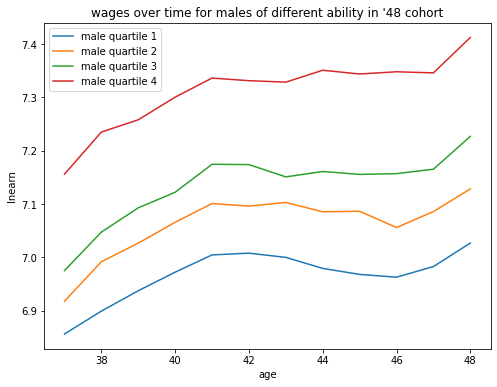

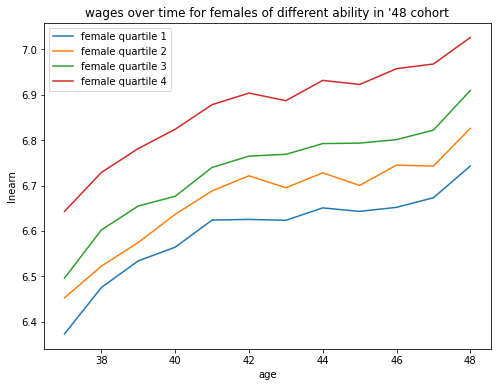

In [688]:
# Extracting the data
egea_df['abil_quartiles'] = pd.qcut(egea_df_X['abil1'], 4, labels=False) + 1
groups = egea_df[['d53', 'lnearn', 'abil_quartiles', 'female', 'age']].groupby(['d53', 'female', 'age', 'abil_quartiles'], as_index = False).mean()
sub_groups = groups.groupby(['d53', 'female', 'abil_quartiles'])
group_list = [sub_groups.get_group(x) for x in sub_groups.groups]

# Making figures
plt.figure(figsize = (8, 6))
i = 1
for group in group_list[0:4]:
    label = 'female' if any(group.female) else 'male' 
    plt.plot(group.age, group.lnearn, label = f'{label} quartile {i}')
    if i % 4 == 0:
        i = 0
    i += 1
plt.title('wages over time for males of different ability in \'48 cohort')
plt.xlabel('age')
plt.ylabel('lnearn')
plt.legend()
plt.show()

plt.figure(figsize = (8, 6))
for group in group_list[4:8]:
    label = 'female' if any(group.female) else 'male' 
    plt.plot(group.age, group.lnearn, label = f'{label} quartile {i}')
    if i % 4 == 0:
        i = 0
    i += 1
    
plt.title('wages over time for females of different ability in \'48 cohort')
plt.xlabel('age')
plt.ylabel('lnearn')
plt.legend()
plt.show()

What we see here is in fact much more similarity between ability level than dissimilarity. As noted before, the wages for women climb at a higher rate, which we can visibily see, however, the difference in growth rates between ability levels is very indistinct. If at all, this discrepancy might be seen in the first figure between the 1st and 4th ability level, the 4th ability level (red line) does seem to climb at a marginally higher rate. <br>
Overall, the data in this sample suggests that higher ability people enjoy higher returns to education and that they will also experience marginally quicker wage growth over their career. 

## Conclusion

Based on the analysis carried out in this report, we can answer the following focus questions as such:
1. What are the returns to education and how do they differ by gender? <br>
The returns to education are large and increasing with education level, and females have higher returns to education than males. 
2. How is the time/age profile of earnings shaped by education?<br>
Those with a better education will see faster wage growth over time. 
3. What are the differences between men and women in educational attainment and career profiles of earnings and how does the gender gap change with age?<br>
Educational attainment between men and women is similar except for at the doctorate level. If anything, there was a slight negative coefficient on educational attainment against being female, but female also on average study for marginally longer than males. In terms of the gender gap, it was found that the gap decreases over time, with females enjoying faster wage growth over time.
4. What is the role of ability in shaping the returns to education? Does this differ by gender <br>
Ability has a positive typically increasing effect on the returns to education. There is a slight difference between gender, with women not seeing as positive of a relationship, but this difference is slight.   <br>

This report has found clear relationships between education ability and earnings, and has also illustrated the different interactions that males and females have between these variables, however, there is still much work to be done in establishing the causality of the results found. Future research might seek to answer questions such as why does the gender gap decrease over time? Or why is higher education correlated with higher wage growt and is the relationship causal? In this vitally important area of research, finding robust answers to these questions is deeply important. 